In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datetime import datetime
%matplotlib inline

## 0. Check Sagemaker Version

In [2]:
!pip install sagemaker==1.72.0

     |████████████████████████████████| 297 kB 14.4 MB/s eta 0:00:01
  Created wheel for sagemaker: filename=sagemaker-1.72.0-py2.py3-none-any.whl size=386358 sha256=c82e273862c53a022036f40ada0174004119d97835168021cd7afdb8f84c2768
  Stored in directory: /home/ec2-user/.cache/pip/wheels/c3/58/70/85faf4437568bfaa4c419937569ba1fe54d44c5db42406bbd7
Successfully built sagemaker
  Attempting uninstall: smdebug-rulesconfig
    Found existing installation: smdebug-rulesconfig 1.0.1
    Uninstalling smdebug-rulesconfig-1.0.1:
      Successfully uninstalled smdebug-rulesconfig-1.0.1
  Attempting uninstall: sagemaker
    Found existing installation: sagemaker 2.29.2
    Uninstalling sagemaker-2.29.2:
      Successfully uninstalled sagemaker-2.29.2


## 1. Read Data and set Datetime as index

In [3]:
# Read csv file
file_path = 'data/traffic_tch_all.csv'
output_path = 'benchmark_tch.csv'


dateparse = lambda x: datetime.strptime(x, '%Y-%m-%d')
df = pd.read_csv(file_path,
                 parse_dates={'Date': ['date']}, 
                 date_parser=dateparse)

df['datetime'] = df['Date'] + df['time'].astype('timedelta64[h]')


df = df.set_index('datetime').asfreq('1H') #generate missing hours
df.fillna(0,inplace=True) #fill missing hours with 0
df = df[['people']]

display(df.info())
display(df.head())

# Check if there is nan
display(df['people'].isnull().values.any())


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8784 entries, 2020-01-01 00:00:00 to 2020-12-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   people  8784 non-null   float64
dtypes: float64(1)
memory usage: 137.2 KB


None

,people
datetime,
2020-01-01 00:00:00,740.0
2020-01-01 01:00:00,8.0
2020-01-01 02:00:00,0.0
2020-01-01 03:00:00,0.0
2020-01-01 04:00:00,0.0


False

## 2. Visualization 

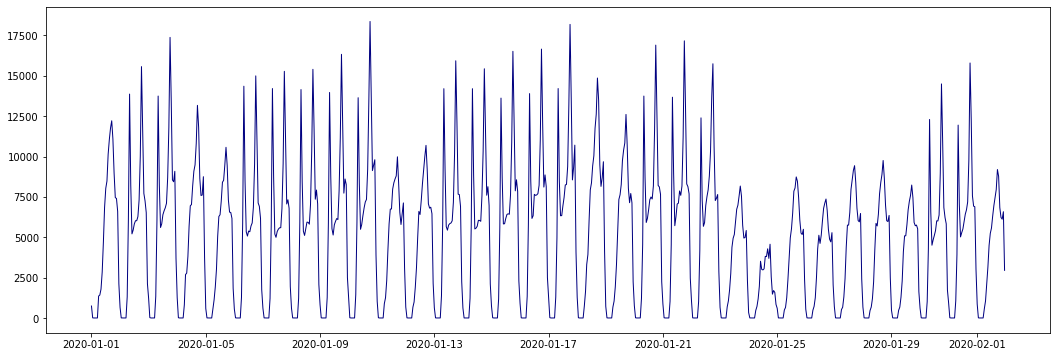

In [4]:
#df.loc['2020-12-31 00:00':'2020-12-31 23:30']

df_plot=df.loc['2020-01-01':'2020-02-01']
fig, (ax1) = plt.subplots(1,1,figsize=(18, 6))
ax1.plot(df_plot.reset_index()['datetime'], df_plot['people'], color='navy', linewidth=1)
#ax2.plot(df.reset_index()['datetime'], df['people'], color='navy', linewidth=1)


## 3. Generate train data

In [5]:
df_train = df.loc['2020-01-01':'2020-11-30'].copy()
df_train

,people
datetime,
2020-01-01 00:00:00,740.0
2020-01-01 01:00:00,8.0
2020-01-01 02:00:00,0.0
2020-01-01 03:00:00,0.0
2020-01-01 04:00:00,0.0
...,...
2020-11-30 19:00:00,11590.0
2020-11-30 20:00:00,7263.0
2020-11-30 21:00:00,6760.0


## 4. Conver to JSON

In [6]:
def series_to_json_obj(ts):
    '''Returns a dictionary of values in DeepAR, JSON format.
       :param ts: A single time series.
       :return: A dictionary of values with "start" and "target" keys.
       '''
    # get start time and target from the time series, ts
    json_obj = {"start": str(ts.index[0]), "target": list(ts)}
    return json_obj

In [7]:
start_dt = '2020-01-01'
end_dt = '2020-11-30'

json_obj = series_to_json_obj( df_train[start_dt:end_dt].squeeze() )


In [8]:
# import json for formatting data
import json
import os # and os for saving

def write_json_dataset(time_series, filename): 
    time_series = time_series.squeeze()
    with open(filename, 'wb') as f:
        json_line = json.dumps(series_to_json_obj(time_series)) + '\n'
        json_line = json_line.encode('utf-8')
        f.write(json_line)
    print(filename + ' saved.')

In [9]:
# save this data to a local directory
data_dir = 'json_traffic_data'

# make data dir, if it does not exist
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

In [10]:
# directories to save train/test data
train_key = os.path.join(data_dir, 'train.json')
test_key = os.path.join(data_dir, 'test.json')

# write train/test JSON files
write_json_dataset(df_train, train_key)        
write_json_dataset(df, test_key)

json_traffic_data/train.json saved.
json_traffic_data/test.json saved.


## 5. Upload data to S3

In [11]:
import boto3
import sagemaker
from sagemaker import get_execution_role

In [12]:
# session, role, bucket
sagemaker_session = sagemaker.Session()
role = get_execution_role()

bucket = sagemaker_session.default_bucket()

In [13]:
# general prefix
prefix='MRT_traffic_data'

# *unique* train/test prefixes
train_prefix   = '{}/{}'.format(prefix, 'train')
test_prefix    = '{}/{}'.format(prefix, 'test')

# uploading data to S3, and saving locations
train_path  = sagemaker_session.upload_data(train_key, bucket=bucket, key_prefix=train_prefix)
test_path   = sagemaker_session.upload_data(test_key,  bucket=bucket, key_prefix=test_prefix)

In [14]:
# check locations
print('Training data is stored in: '+ train_path)
print('Test data is stored in: '+ test_path)

Training data is stored in: s3://sagemaker-us-east-1-716934411671/MRT_traffic_data/train/train.json
Test data is stored in: s3://sagemaker-us-east-1-716934411671/MRT_traffic_data/test/test.json


## 6. Training DeepAR Estimator

In [15]:
from sagemaker.amazon.amazon_estimator import get_image_uri

image_name = get_image_uri(boto3.Session().region_name, # get the region
                           'forecasting-deepar') # specify image

'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


In [16]:
from sagemaker.estimator import Estimator

# dir to save model artifacts
s3_output_path = "s3://{}/{}/output".format(bucket, prefix)

# instantiate a DeepAR estimator
estimator = Estimator(sagemaker_session=sagemaker_session,
                      image_name=image_name,
                      role=role,
                      train_instance_count=1,
                      train_instance_type='ml.c4.xlarge',
                      output_path=s3_output_path
                      )

Parameter image_name will be renamed to image_uri in SageMaker Python SDK v2.


## 7. Setting Hyperparameters

In [17]:
freq='H'
prediction_length=744
context_length=744 # same as prediction_length

hyperparameters = {
    "epochs": "50",
    "time_freq": freq,
    "prediction_length": str(prediction_length),
    "context_length": str(context_length),
    "num_cells": "50",
    "num_layers": "2",
    "mini_batch_size": "128",
    "learning_rate": "0.001",
    "early_stopping_patience": "10"
}

In [18]:
# set the hyperparams
estimator.set_hyperparameters(**hyperparameters)

## 8. Training Job

In [19]:
%%time
# train and test channels
data_channels = {
    "train": train_path,
    "test": test_path
}

# fit the estimator
estimator.fit(inputs=data_channels)

's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.


2021-03-08 05:38:24 Starting - Starting the training job...
2021-03-08 05:38:26 Starting - Launching requested ML instances......
2021-03-08 05:39:39 Starting - Preparing the instances for training......
2021-03-08 05:40:53 Downloading - Downloading input data
2021-03-08 05:40:53 Training - Downloading the training image.....Arguments: train
[03/08/2021 05:41:34 INFO 139727263536960] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'num_dynamic_feat': u'auto', u'dropout_rate': u'0.10', u'mini_batch_size': u'128', u'test_quantiles': u'[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'num_eval_samples': u'100', u'learning_rate': u'0.001', u'num_cells': u'40', u'num_layers': u'2', u'embedding_dimension': u'10', u'_kvstore': u'auto', u'_num_kv_servers': u'auto', u'cardinality': u'auto', u'likelihood': u'student-t', u'early_stopping_patience': u''}
[03/08/2021 05:41:3

## 9. Deploy and Create a Predictor

In [20]:
%%time

# create a predictor
predictor = estimator.deploy(
    initial_instance_count=1,
    instance_type='ml.t2.medium',
    content_type="application/json" # specify that it will accept/produce JSON
)

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.


-------------------!CPU times: user 312 ms, sys: 43 ms, total: 355 ms
Wall time: 9min 32s


## 10. JSON Prediction Request

In [21]:
def json_predictor_input(input_ts, num_samples=50, quantiles=['0.1', '0.5', '0.9']):
    '''Accepts a list of input time series and produces a formatted input.
       :input_ts: An list of input time series.
       :num_samples: Number of samples to calculate metrics with.
       :quantiles: A list of quantiles to return in the predicted output.
       :return: The JSON-formatted input.
       '''
    # request data is made of JSON objects (instances)
    # and an output configuration that details the type of data/quantiles we want
    
    instances = []
    #for k in range(len(input_ts)):
        # get JSON objects for input time series
    instances.append(series_to_json_obj(input_ts))

    # specify the output quantiles and samples
    configuration = {"num_samples": num_samples, 
                     "output_types": ["quantiles"], 
                     "quantiles": quantiles}

    request_data = {"instances": instances, 
                    "configuration": configuration}

    json_request = json.dumps(request_data).encode('utf-8')
    
    return json_request

In [22]:
df_train.squeeze()

datetime
2020-01-01 00:00:00      740.0
2020-01-01 01:00:00        8.0
2020-01-01 02:00:00        0.0
2020-01-01 03:00:00        0.0
2020-01-01 04:00:00        0.0
                        ...   
2020-11-30 19:00:00    11590.0
2020-11-30 20:00:00     7263.0
2020-11-30 21:00:00     6760.0
2020-11-30 22:00:00     5745.0
2020-11-30 23:00:00     1531.0
Freq: H, Name: people, Length: 8040, dtype: float64

### Get a prediction

In [23]:
# get all input and target (test) time series
input_ts = df_train.squeeze()
target_ts = df.squeeze()

# get formatted input time series
json_input_ts = json_predictor_input(input_ts)

# get the prediction from the predictor
json_prediction = predictor.predict(json_input_ts)

#print(json_prediction)

### Decode Prediction

In [24]:
# helper function to decode JSON prediction
def decode_prediction(prediction, encoding='utf-8'):
    '''Accepts a JSON prediction and returns a list of prediction data.
    '''
    prediction_data = json.loads(prediction.decode(encoding))
    prediction_list = []
    for k in range(len(prediction_data['predictions'])):
        prediction_list.append(pd.DataFrame(data=prediction_data['predictions'][k]['quantiles']))
    return prediction_list


In [25]:
# get quantiles/predictions
prediction_list = decode_prediction(json_prediction)

# should get a list of 30 predictions 
# with corresponding quantile values
print(prediction_list[0])

              0.1           0.9           0.5
0      353.184509    549.321106    448.010406
1     -117.245438     -7.883698    -64.798088
2      -85.123268     13.308910    -40.204784
3      -87.593658     30.474510    -35.383018
4      -85.661545    -11.682888    -48.394951
..            ...           ...           ...
739  10173.890625  12584.135742  11426.149414
740   6207.488281   7422.416016   6860.208496
741   5914.208984   7166.861816   6571.866211
742   5131.500000   6494.224609   5696.298828
743   1363.237549   2064.181396   1686.144287

[744 rows x 3 columns]


## 11. Display the results

In [26]:
#set index for integer to datetime
def int_to_datetime(df_input):
    df_out = df_input[0].copy()
    df_out['datetime'] = pd.to_datetime('2020-12-01')
    df_out['index'] = df_out.index
    df_out['datetime'] = df_out['datetime'] + df_out['index'].astype('timedelta64[h]')
    df_out.drop(columns=['index'], inplace=True)
    df_out.set_index('datetime')
    out_list = []
    out_list.append(df_out)
    
    return out_list

# display the prediction median against the actual data
def display_quantiles(prediction_list, date_start, date_end, target_ts=None):
    # show predictions for all input ts
    x_axis = None
    for k in range(len(prediction_list)):
        plt.figure(figsize=(18,6))
        # get the target month of data
        if target_ts is not None:
            target = target_ts[-prediction_length:]
            
            x_axis = target.index[(target.index > date_start) & (target.index < date_end)]
            
            plt.plot(x_axis, target[(target.index > date_start) & (target.index < date_end)], label='target')
        # get the quantile values at 10 and 90%
        p10 = prediction_list[k]['0.1']
        p90 = prediction_list[k]['0.9']
        # fill the 80% confidence interval
        plt.fill_between(x_axis, 
                         p10[(target.index > date_start) & (target.index < date_end)], 
                         p90[(target.index > date_start) & (target.index < date_end)], 
                         color='y', alpha=0.5, label='80% confidence interval')
        # plot the median prediction line
        plt.plot(x_axis, prediction_list[k][(target.index > date_start) & (target.index < date_end)]['0.5'], label='prediction median')
        #prediction_list[k]['0.5'].plot(label='prediction median')
        plt.legend()
        plt.show()

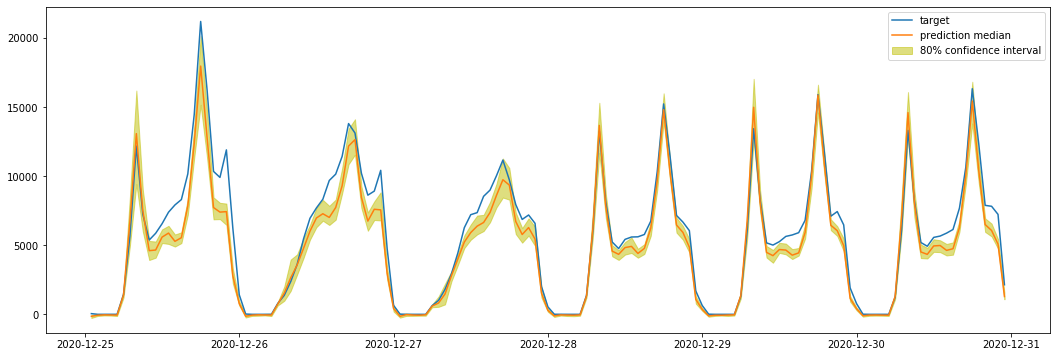

In [27]:
# display predictions
display_quantiles(int_to_datetime(prediction_list),'2020-12-25 00', '2020-12-31 00' , target_ts)

In [28]:
df_prediction = pd.DataFrame(int_to_datetime(prediction_list)[0]).set_index('datetime')
df_target = pd.DataFrame(target_ts)

df_benchmark = pd.merge(df_prediction, df_target, left_index=True, right_index=True)
df_benchmark.rename(columns={'people':'target'}, inplace=True)
df_benchmark.to_csv(output_path)

In [29]:
## TODO: delete the endpoint
predictor.delete_endpoint()